In [84]:
import pandas as pd
from datetime import date, datetime
from typing import Union
import requests
import mysql.connector
from cache import Cache
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
import plotly.express as px

#!pip install plotly

RESALE = "resale.csv"
HDBINFO = "hdb_info.csv"

resale = pd.read_csv(RESALE)
hdb_info = pd.read_csv(HDBINFO)

towns = None
flat_types = None
storey_ranges = None

resale.drop(resale.columns[resale.columns.str.contains('unnamed',case = False)], axis=1, inplace=True)
hdb_info.drop(hdb_info.columns[hdb_info.columns.str.contains('unnamed',case = False)], axis=1, inplace=True)

# Create a dictionary mapping towns to their respective regions
town_to_region = {
    'ANG MO KIO': 'North-East',
    'BEDOK': 'East',
    'BISHAN': 'Central',
    'BUKIT BATOK': 'West',
    'BUKIT MERAH': 'Central',
    'BUKIT PANJANG': 'West',
    'BUKIT TIMAH': 'Central',
    'CENTRAL AREA': 'Central',
    'CHOA CHU KANG': 'West',
    'CLEMENTI': 'West',
    'GEYLANG': 'Central',
    'HOUGANG': 'North-East',
    'JURONG EAST': 'West',
    'JURONG WEST': 'West',
    'KALLANG/WHAMPOA': 'Central',
    'MARINE PARADE': 'Central',
    'PASIR RIS': 'East',
    'PUNGGOL': 'North-East',
    'QUEENSTOWN': 'Central',
    'SEMBAWANG': 'North',
    'SENGKANG': 'North-East',
    'SERANGOON': 'North-East',
    'TAMPINES': 'East',
    'TOA PAYOH': 'Central',
    'WOODLANDS': 'North',
    'YISHUN': 'North'
}

# Create a new column 'region' in your DataFrame based on the mapping
resale['region'] = resale['town'].map(town_to_region)

resale_copy = resale.copy()

towns = list(resale_copy["town"].unique())
towns.sort()
flat_types = list(resale_copy["flat_type"].unique())
flat_types.sort()
storey_ranges = list(resale_copy["storey_range"].unique())
storey_ranges.sort()

df = pd.merge(resale, hdb_info, on='postal_code')

In [12]:
# encode categorial variables
resale_copy = pd.get_dummies(resale_copy, columns=["town", "flat_type", "storey_range", "flat_model"])
resale_copy.columns = resale_copy.columns.str.replace(" ","")
resale_copy.columns = resale_copy.columns.str.replace("/","_")

In [13]:
def getHouseInfo(postal_code) -> dict:
        return hdb_info.loc[hdb_info["postal_code"] == postal_code].iloc[0]
    
def getRemainingLease(postal_code) -> int:
        return (date.today().year - int(hdb_info.loc[hdb_info["postal_code"] == postal_code]["year_completed"])) * 12
    
def getAllPostalCodes(self) -> list:
        return hdb_info["postal_code"].values

def getTowns(self) -> list:
        return towns
    
def getFlatTypes(self) -> list:
        return self.__flat_types
    
def getStoreyRanges(self) -> list:
        return self.__storey_ranges

def getHistory(self , postal_code):
        data = self.__resale.loc[self.__resale["postal_code"] == postal_code].to_dict("records")
        return data if data else None

def getSoldHDBsInTown(self, town, page):
        data = self.__resale.loc[self.__resale["town"] == town].to_dict("records")[(page*10)-10:page*10]
        return {"results" : data} if data else {"results" : None}

In [14]:
getRemainingLease("530550")

396

In [15]:
getHouseInfo("530550")

blk_no                                 550
street                       HOUGANG ST 51
max_floor_lvl                           13
year_completed                        1990
residential                              Y
commercial                               N
market_hawker                            N
miscellaneous                            Y
multistorey_carpark                      N
precinct_pavilion                        N
bldg_contract_town                      HG
total_dwelling_units                    76
1room_sold                               0
2room_sold                               0
3room_sold                               0
4room_sold                              76
5room_sold                               0
exec_sold                                0
multigen_sold                            0
studio_apartment_sold                    0
1room_rental                             0
2room_rental                             0
3room_rental                             0
other_room_

In [16]:
print(towns)
print(flat_types)
print(storey_ranges)

['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL', 'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN']
['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15', '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30', '31 TO 33', '34 TO 36', '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51']


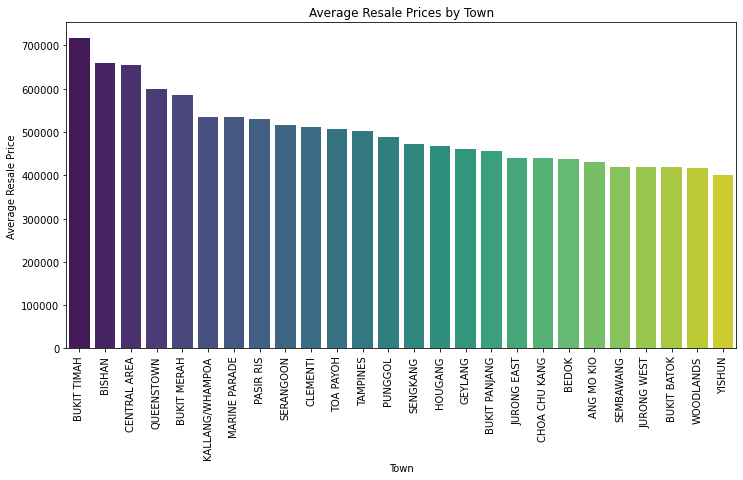

In [17]:
# Calculate average prices per town
average_prices_by_town = resale.groupby('town')['resale_price'].mean().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=average_prices_by_town.index, y=average_prices_by_town.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Average Resale Prices by Town')
plt.xlabel('Town')
plt.ylabel('Average Resale Price')
plt.show()

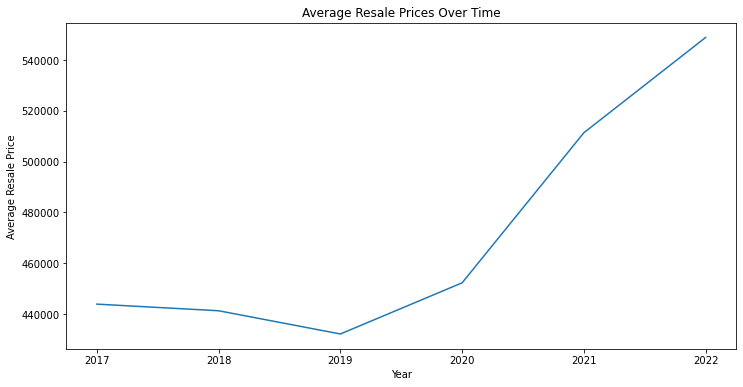

In [18]:
# Convert 'month' column to datetime
resale['month'] = pd.to_datetime(resale['month'])

# Group by year and calculate average prices
average_prices_by_year = resale.groupby(resale['month'].dt.year)['resale_price'].mean()

# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(x=average_prices_by_year.index, y=average_prices_by_year.values)
plt.title('Average Resale Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Average Resale Price')
plt.show()

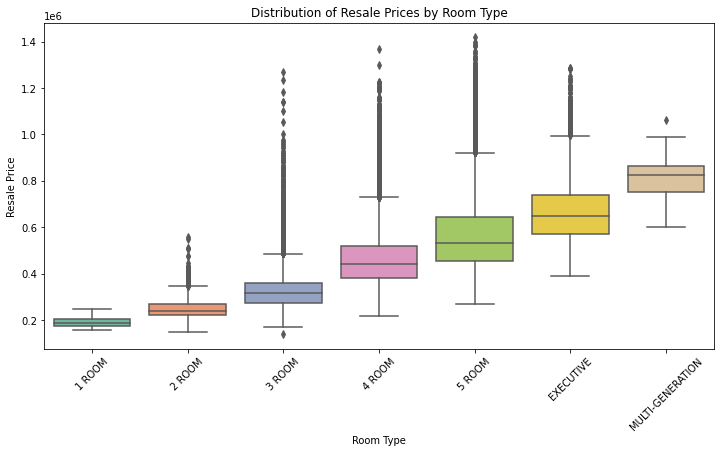

In [19]:
# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='flat_type', y='resale_price', data=resale, order=flat_types, palette='Set2')
plt.xticks(rotation=45)
plt.title('Distribution of Resale Prices by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Resale Price')
plt.show()

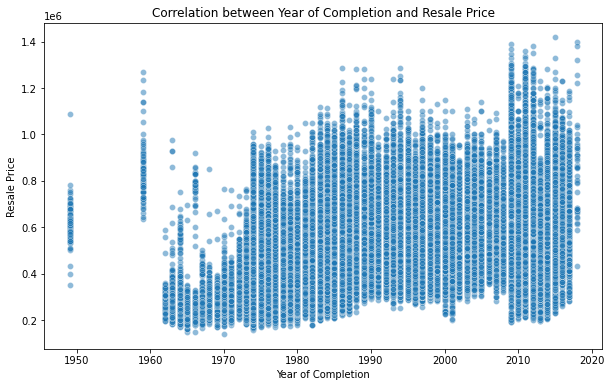

In [20]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year_completed', y='resale_price', data=df, alpha=0.5)
plt.title('Correlation between Year of Completion and Resale Price')
plt.xlabel('Year of Completion')
plt.ylabel('Resale Price')
plt.show()

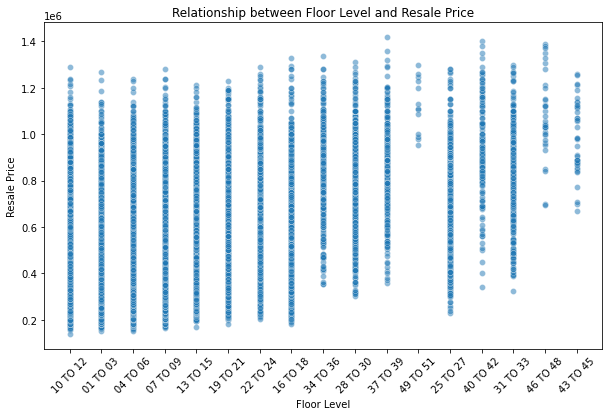

In [77]:
custom_order = [
    '01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15',
    '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30',
    '31 TO 33', '34 TO 36', '37 TO 39', '40 TO 42', '43 TO 45',
    '46 TO 48', '49 TO 51'
]
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='storey_range', y='resale_price', data=resale, alpha=0.5)
plt.xticks(rotation=45)
plt.title('Relationship between Floor Level and Resale Price')
plt.xlabel('Floor Level')
plt.ylabel('Resale Price')
plt.show()



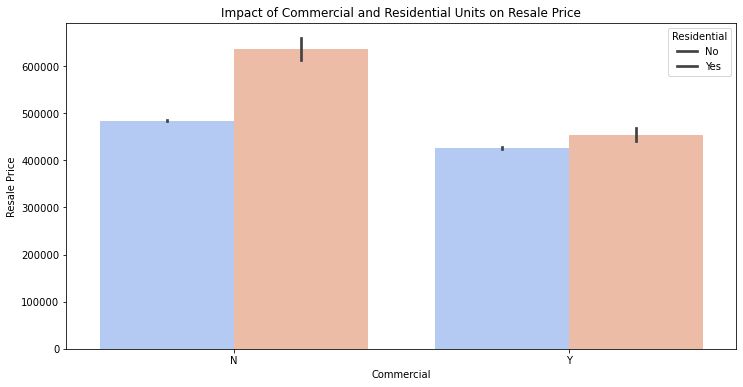

In [78]:
# Create a grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='commercial', y='resale_price', hue='residential', data=df, palette='coolwarm')
plt.title('Impact of Commercial and Residential Units on Resale Price')
plt.xlabel('Commercial')
plt.ylabel('Resale Price')
plt.legend(title='Residential', loc='upper right', labels=['No', 'Yes'])
plt.show()

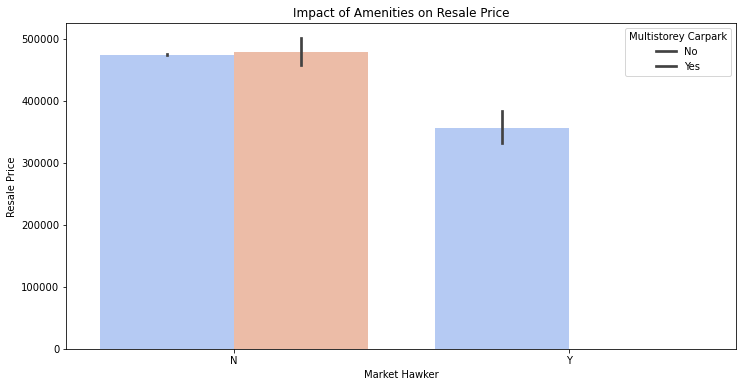

In [29]:
# Create a grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='market_hawker', y='resale_price', hue='multistorey_carpark', data=df, palette='coolwarm')
plt.title('Impact of Amenities on Resale Price')
plt.xlabel('Market Hawker')
plt.ylabel('Resale Price')
plt.legend(title='Multistorey Carpark', loc='upper right', labels=['No', 'Yes'])
plt.show()

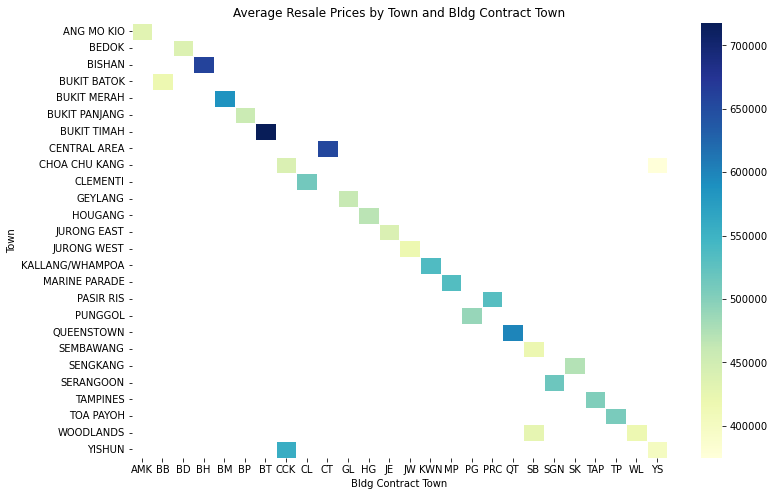

In [31]:
# Create a heatmap to visualize average prices by town
town_price_matrix = df.pivot_table(index='town', columns='bldg_contract_town', values='resale_price', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(town_price_matrix, cmap='YlGnBu', linewidths=0.5)
plt.title('Average Resale Prices by Town and Bldg Contract Town')
plt.xlabel('Bldg Contract Town')
plt.ylabel('Town')
plt.show()


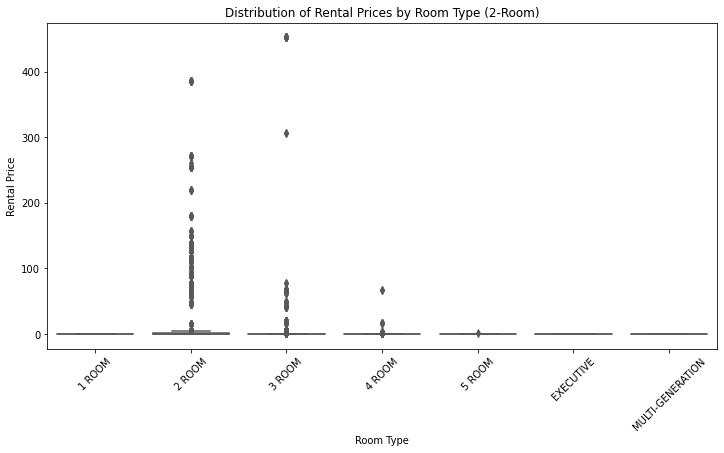

In [37]:
# Create a box plot for rental prices
plt.figure(figsize=(12, 6))
sns.boxplot(x='flat_type', y='2room_rental', data=df, order=flat_types, palette='Set2')
plt.xticks(rotation=45)
plt.title('Distribution of Rental Prices by Room Type (2-Room)')
plt.xlabel('Room Type')
plt.ylabel('Rental Price')
plt.show()


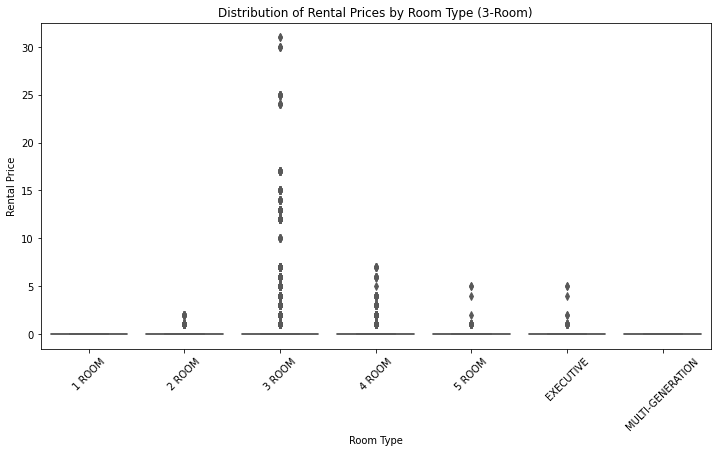

In [39]:
# Create a box plot for rental prices
plt.figure(figsize=(12, 6))
sns.boxplot(x='flat_type', y='3room_rental', data=df, order=flat_types, palette='Set2')
plt.xticks(rotation=45)
plt.title('Distribution of Rental Prices by Room Type (3-Room)')
plt.xlabel('Room Type')
plt.ylabel('Rental Price')
plt.show()


In [59]:
#print(df[df['flat_type'] == 'EXECUTIVE'][['resale_price', 'studio_apartment_sold', '2room_rental', 'flat_type']])
# Create a side-by-side bar chart
studio_prices = df[df['flat_type'] == 'EXECUTIVE'][['resale_price', 'studio_apartment_sold', '2room_rental', 'flat_type']]
studio_prices = studio_prices.rename(columns={'resale_price': 'Sale Price', 'studio_apartment_sold': 'Sale Count', '2room_rental': 'Rental Price'})
studio_prices.plot(x='flat_type', kind='bar', figsize=(10, 6))
plt.title('Comparison of Sale and Rental Prices for Studio Apartments')
plt.xlabel('Flat Type')
plt.ylabel('Price')
plt.show()


        resale_price  studio_apartment_sold  2room_rental  flat_type
96          850000.0                      0             0  EXECUTIVE
198         700000.0                      0             0  EXECUTIVE
357         900000.0                      0             0  EXECUTIVE
511         855000.0                      0             0  EXECUTIVE
637         835000.0                      0             0  EXECUTIVE
...              ...                    ...           ...        ...
137795      720000.0                      0             0  EXECUTIVE
137858      640000.0                      0             0  EXECUTIVE
138251      985000.0                      0             0  EXECUTIVE
138353      810000.0                      0             0  EXECUTIVE
138400      650000.0                      0             0  EXECUTIVE

[10960 rows x 4 columns]


KeyboardInterrupt: 

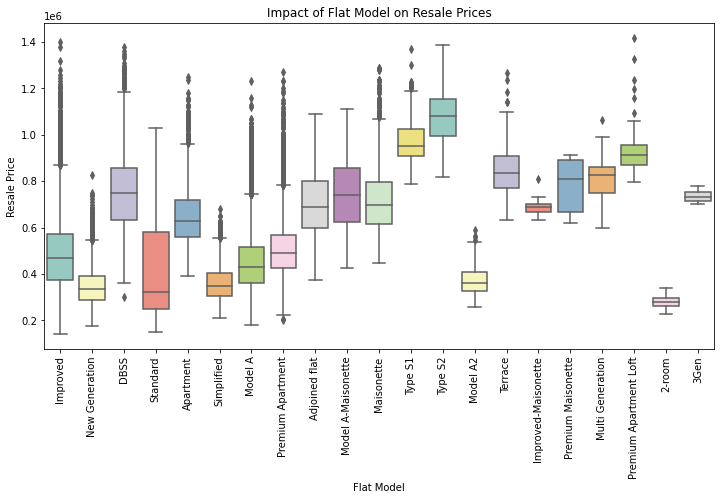

In [42]:
# Create a box plot for resale prices by flat model
plt.figure(figsize=(12, 6))
sns.boxplot(x='flat_model', y='resale_price', data=resale, palette='Set3')
plt.xticks(rotation=90)
plt.title('Impact of Flat Model on Resale Prices')
plt.xlabel('Flat Model')
plt.ylabel('Resale Price')
plt.show()


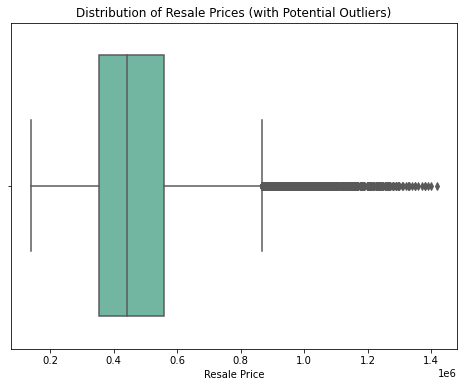

In [43]:
# Create a box plot to visualize potential outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=resale['resale_price'], palette='Set2')
plt.title('Distribution of Resale Prices (with Potential Outliers)')
plt.xlabel('Resale Price')
plt.show()


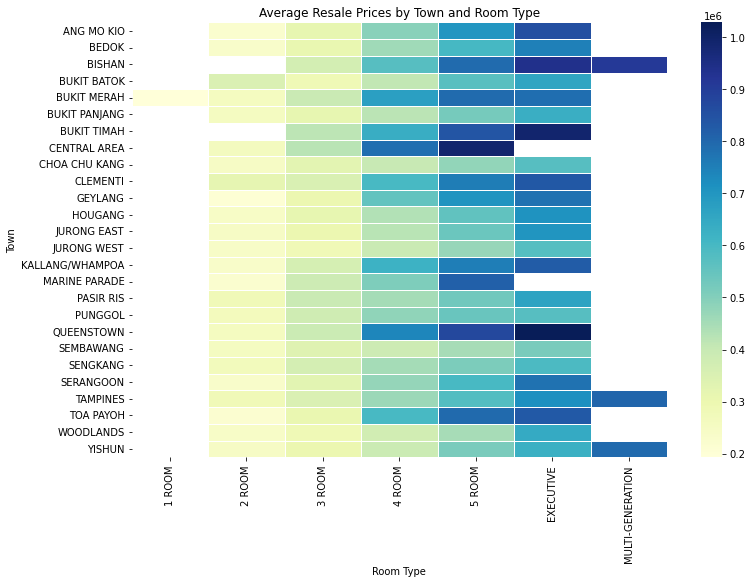

In [79]:
# Pivot the DataFrame to compare room types across towns
town_room_matrix = df.pivot_table(index='town', columns='flat_type', values='resale_price', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(town_room_matrix, cmap='YlGnBu', linewidths=0.5)
plt.title('Average Resale Prices by Town and Room Type')
plt.xlabel('Room Type')
plt.ylabel('Town')
plt.show()


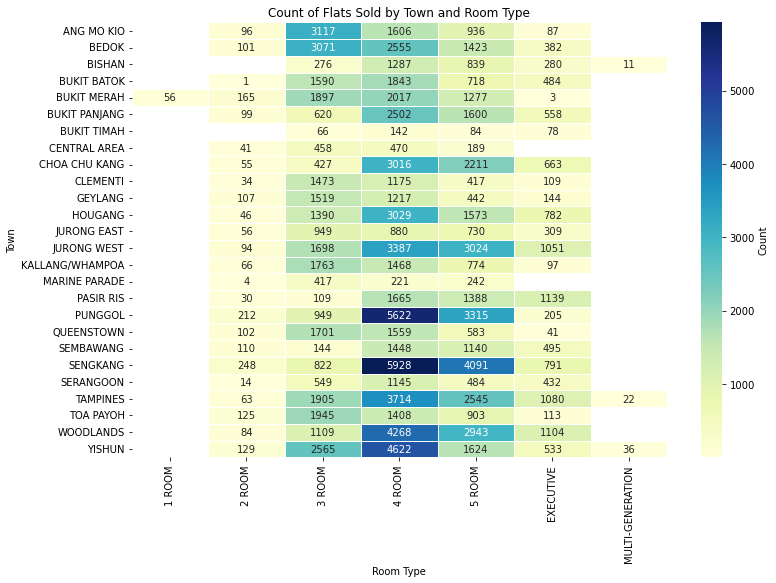

In [81]:
# Pivot the DataFrame to compare room types across towns and count the occurrences
town_room_count_matrix = df.pivot_table(index='town', columns='flat_type', values='resale_price', aggfunc='count')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(town_room_count_matrix, cmap='YlGnBu', linewidths=0.5, annot=True, fmt='.0f', cbar_kws={'label': 'Count'})
plt.title('Count of Flats Sold by Town and Room Type')
plt.xlabel('Room Type')
plt.ylabel('Town')
plt.show()


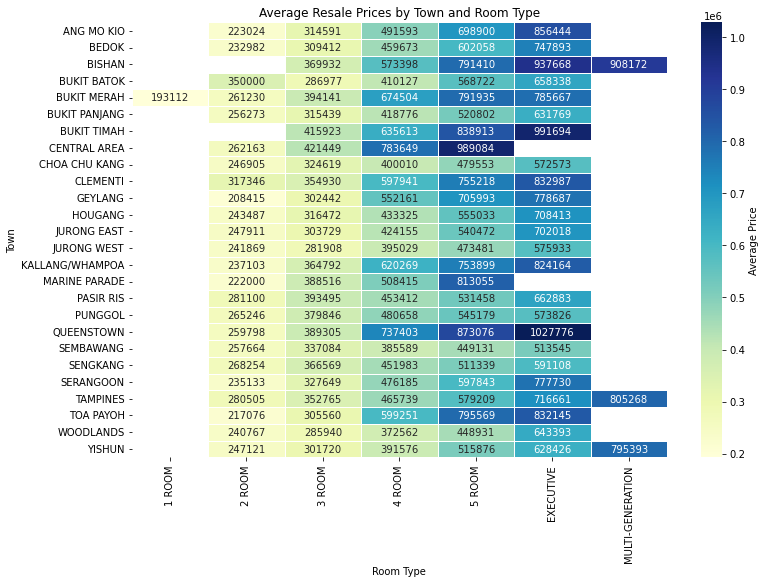

In [82]:
# Pivot the DataFrame to compare room types across towns and calculate average prices
town_room_price_matrix = df.pivot_table(index='town', columns='flat_type', values='resale_price', aggfunc='mean')

# Sort columns (room types) by average price
sorted_columns = town_room_price_matrix.mean().sort_values().index
town_room_price_matrix = town_room_price_matrix[sorted_columns]

# Create a heatmap with color-coded room types
plt.figure(figsize=(12, 8))
sns.heatmap(town_room_price_matrix, cmap='YlGnBu', linewidths=0.5, annot=True, fmt='.0f', cbar_kws={'label': 'Average Price'})
plt.title('Average Resale Prices by Town and Room Type')
plt.xlabel('Room Type')
plt.ylabel('Town')
plt.show()


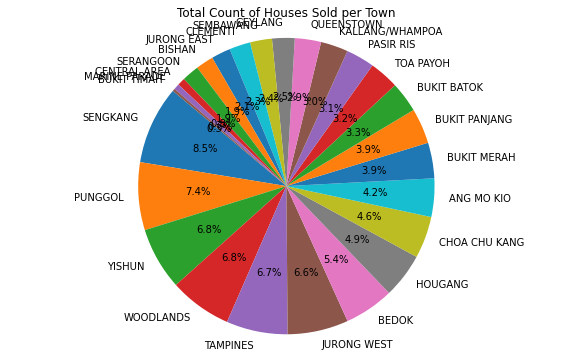

In [83]:
# Group the data by town and calculate the total count
town_counts = df['town'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(town_counts, labels=town_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Count of Houses Sold per Town')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

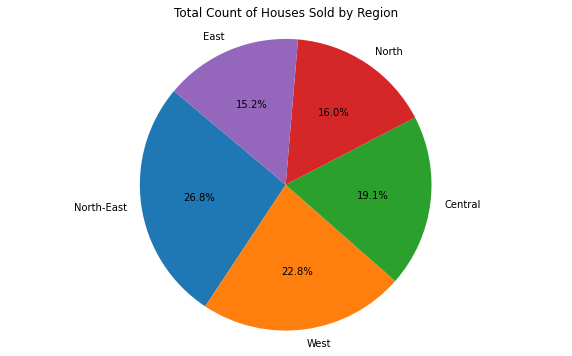

In [85]:
# Group the data by region and calculate the total count
region_counts = resale['region'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Count of Houses Sold by Region')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

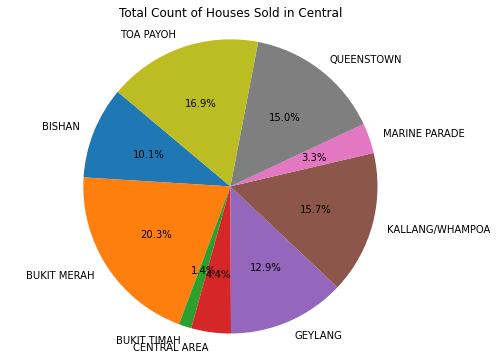

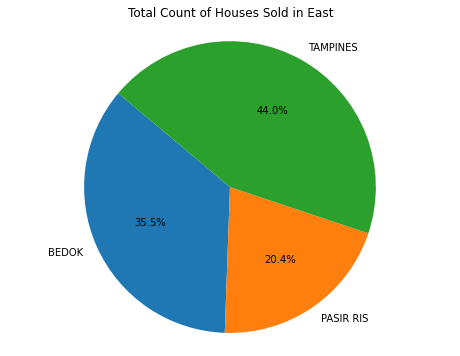

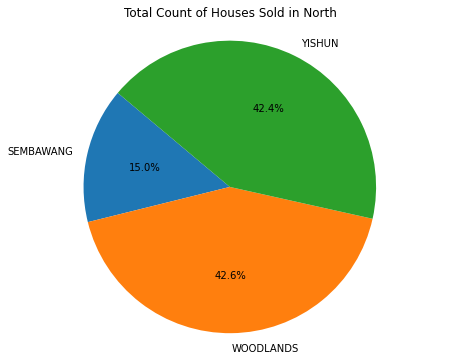

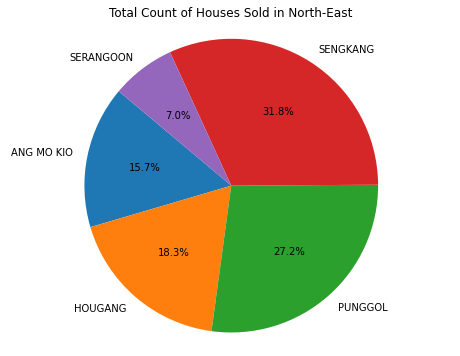

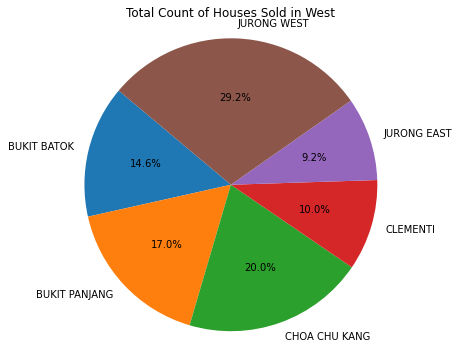

In [86]:
grouped = resale.groupby(['region', 'town']).size().reset_index(name='count')

# Iterate through each region and create a pie chart for towns
regions = grouped['region'].unique()

for region in regions:
    region_data = grouped[grouped['region'] == region]
    
    # Create a pie chart for the region
    plt.figure(figsize=(8, 6))
    plt.pie(region_data['count'], labels=region_data['town'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Total Count of Houses Sold in {region}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [105]:
import geopandas as gpd
from shapely.geometry import Point

# Load the GeoJSON file using geopandas
gdf = gpd.read_file('countries.geo.json')

# Create an example data point (latitude and longitude)
latitude = 1.4589640128389818
longitude = 103.72055053710938

# Create a point object for the data point
data_point = Point(longitude, latitude)

# Check which region the data point falls within
for index, row in gdf.iterrows():
    if row['geometry'].contains(data_point):
        print(f'The data point is in {row["name"]}')
        break
